<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Repo already exists at: /content/ZZSC9020-Group_F
Pulling changes from repo...
Already up to date.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
## import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [6]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [7]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [8]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [9]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [10]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [ ]:
'''## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_int("n_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [14]:
demandDF = test_df[['avg_30_min_demand']]

In [15]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [16]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='avg_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [17]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1023 - mean_absolute_percentage_error: 280096.1562 - root_mean_squared_error: 0.3129 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 51.8121 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - mean_absolute_percentage_error: 1243151.5000 - root_mean_squared_error: 0.1463 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 35.1617 - val_root_mean_squared_error: 0.1137
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mean_absolute_percentage_error: 1113142.6250 - root_mean_squared_error: 0.1318 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 35.7316 - val_root_mean_squared_error: 0.1126
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168 - mean_absolute_percentage_error: 1099892.8750 - root_mean_squared_error: 0.1296 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 36.2724 - val_root_mean_squared_error: 0.11

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


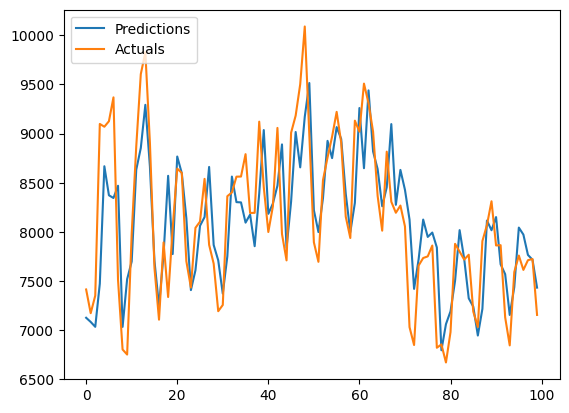

MAPE: 3.93%
RMSE: 426.75
MAE : 317.81


Predictions      Actuals
0    7124.750000  7412.811667
1    7082.223145  7171.183125
2    7032.539551  7350.264167
3    7471.372559  9098.258333
4    8667.603516  9070.002917
..           ...          ...
719  7912.625000  7374.332292
720  7874.966309  8039.583333
721  8215.955078  8575.767292
722  8444.435547  7909.507917
723  7630.507324  7144.386250

[724 rows x 2 columns]

In [19]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

In [20]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.77%
RMSE: 390.24
MAE : 299.84


Predictions      Actuals
0    8707.712891  9537.097917
1    8796.160156  8863.333125
2    8138.233398  7973.787500
3    7759.328125  8194.981667
4    8413.875977  9096.434375
..           ...          ...
353  8011.341797  8447.030417
354  8189.777344  8771.408958
355  7978.222656  8487.014792
356  7550.789062  8380.489792
357  7652.086426  8437.980833

[358 rows x 2 columns]

In [21]:
predictions_plot(model1, X_test, y_test, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.87%
RMSE: 411.12
MAE : 307.24


Predictions      Actuals
0    8495.968750  8569.568125
1    8568.859375  8540.904167
2    8525.109375  8076.513125
3    8267.402344  8302.971875
4    8293.605469  8440.820000
..           ...          ...
353  7671.625000  7508.199792
354  7795.284180  7694.271458
355  7482.867676  7746.240833
356  7600.391602  8321.401042
357  7877.735352  8503.726875

[358 rows x 2 columns]

### Model 2 - Overlapping Windows ###

In [22]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [23]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1478 - root_mean_squared_error: 0.3830 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - root_mean_squared_error: 0.1659 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

In [25]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.93%
RMSE: 429.05
MAE : 318.64


Predictions      Actuals
0    7034.395508  7412.811667
1    7066.145996  7171.183125
2    7034.455566  7350.264167
3    7461.113281  9098.258333
4    8699.461914  9070.002917
..           ...          ...
719  7925.165039  7374.332292
720  7884.093262  8039.583333
721  8210.942383  8575.767292
722  8432.375000  7909.507917
723  7592.145020  7144.386250

[724 rows x 2 columns]

In [26]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.84%
RMSE: 400.05
MAE : 306.05


Predictions      Actuals
0    6684.022461  7365.989375
1    7163.149902  7895.121667
2    7939.421875  7501.373542
3    7716.580566  7557.751458
4    7983.753906  8021.308125
..           ...          ...
360  8050.454102  8447.030417
361  8133.943848  8771.408958
362  7611.487305  8487.014792
363  7543.132324  8380.489792
364  7665.941895  8437.980833

[365 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


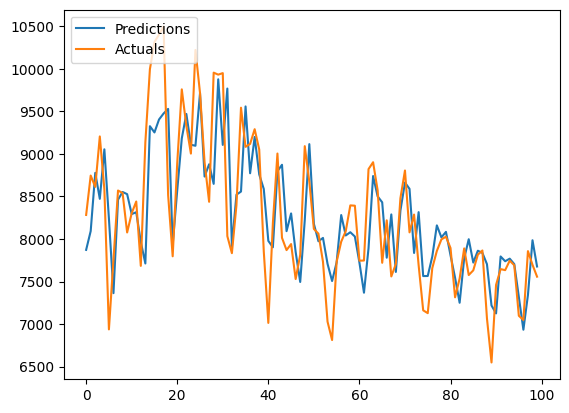

MAPE: 3.94%
RMSE: 419.27
MAE : 313.84


Predictions      Actuals
0    7872.260254  8282.850208
1    8093.434082  8745.688125
2    8777.196289  8612.550625
3    8472.228516  9205.374583
4    9053.986328  8584.935417
..           ...          ...
360  7697.355957  7508.199792
361  7808.648926  7694.271458
362  7439.428223  7746.240833
363  7587.394043  8321.401042
364  7885.881836  8503.726875

[365 rows x 2 columns]

In [27]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [28]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]

In [29]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [30]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0708 - root_mean_squared_error: 0.2602 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

In [32]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.85%
RMSE: 421.95
MAE : 310.92


Predictions      Actuals
0    7054.562988  7412.811667
1    7072.491211  7171.183125
2    7043.955078  7350.264167
3    7491.700684  9098.258333
4    8782.934570  9070.002917
..           ...          ...
719  7971.866211  7374.332292
720  7927.603516  8039.583333
721  8313.397461  8575.767292
722  8516.950195  7909.507917
723  7698.708008  7144.386250

[724 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


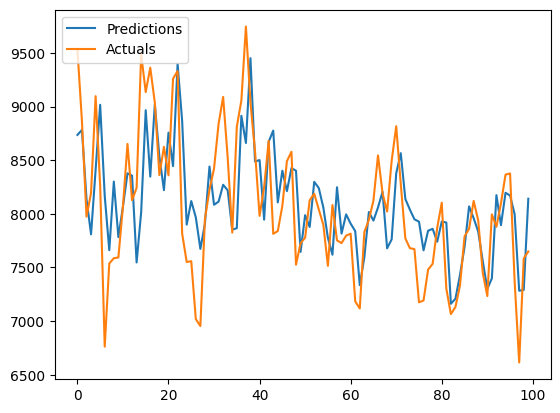

MAPE: 3.74%
RMSE: 386.34
MAE : 297.23


Predictions      Actuals
0    8735.191406  9537.097917
1    8781.917969  8863.333125
2    8137.503906  7973.787500
3    7808.703125  8194.981667
4    8409.464844  9096.434375
..           ...          ...
353  8042.695801  8447.030417
354  8276.114258  8771.408958
355  8055.943359  8487.014792
356  7721.923340  8380.489792
357  7781.788574  8437.980833

[358 rows x 2 columns]

In [33]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

In [34]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.85%
RMSE: 413.34
MAE : 306.50


Predictions      Actuals
0    8445.862305  8569.568125
1    8569.576172  8540.904167
2    8524.605469  8076.513125
3    8234.355469  8302.971875
4    8268.963867  8440.820000
..           ...          ...
353  7732.806641  7508.199792
354  7905.583496  7694.271458
355  7725.717285  7746.240833
356  7815.532715  8321.401042
357  8079.945312  8503.726875

[358 rows x 2 columns]

## Feature Analysis ##

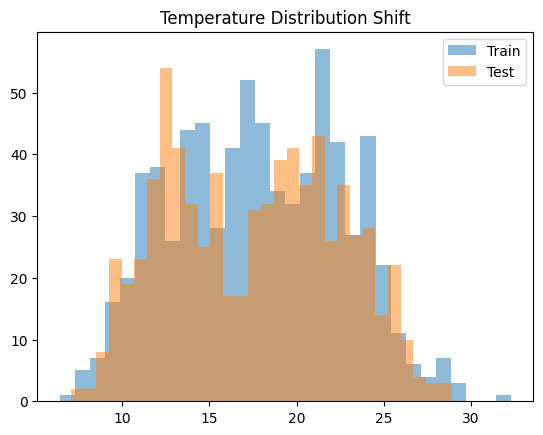

In [35]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [36]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [37]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [38]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1594 - root_mean_squared_error: 0.3879 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [40]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


MAPE: 3.80%
RMSE: 413.46
MAE : 305.96


Predictions      Actuals
0    7037.318848  7412.811667
1    7097.849609  7171.183125
2    7077.787109  7350.264167
3    7549.332520  9098.258333
4    8881.775391  9070.002917
..           ...          ...
719  7905.228516  7374.332292
720  8026.199707  8039.583333
721  8307.684570  8575.767292
722  8459.335938  7909.507917
723  7514.552734  7144.386250

[724 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


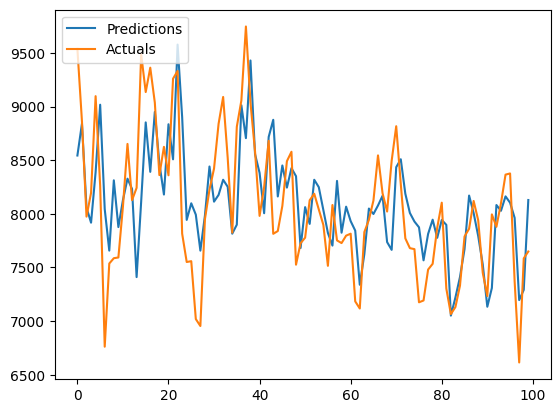

MAPE: 3.73%
RMSE: 386.19
MAE : 295.91


Predictions      Actuals
0    8543.292969  9537.097917
1    8839.968750  8863.333125
2    8058.873535  7973.787500
3    7917.194336  8194.981667
4    8388.342773  9096.434375
..           ...          ...
353  8012.301270  8447.030417
354  8370.956055  8771.408958
355  8272.251953  8487.014792
356  7785.154297  8380.489792
357  7733.948242  8437.980833

[358 rows x 2 columns]

In [41]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

In [42]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.82%
RMSE: 406.75
MAE : 302.84


Predictions      Actuals
0    8352.587891  8569.568125
1    8658.521484  8540.904167
2    8517.171875  8076.513125
3    8290.420898  8302.971875
4    8164.842773  8440.820000
..           ...          ...
353  7778.718262  7508.199792
354  7893.883301  7694.271458
355  7811.335449  7746.240833
356  7825.026855  8321.401042
357  8092.675781  8503.726875

[358 rows x 2 columns]

## Model 5 ##

In [43]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [44]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [45]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0595 - root_mean_squared_error: 0.2385 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

In [47]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.67%
RMSE: 404.21
MAE : 297.40


Predictions      Actuals
0    7095.588867  7412.811667
1    7157.197754  7171.183125
2    7184.828125  7350.264167
3    7516.221680  9098.258333
4    8863.723633  9070.002917
..           ...          ...
719  7899.154297  7374.332292
720  7921.610352  8039.583333
721  8340.816406  8575.767292
722  8571.927734  7909.507917
723  7727.104980  7144.386250

[724 rows x 2 columns]

In [48]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.67%
RMSE: 383.21
MAE : 292.61


Predictions      Actuals
0    8529.039062  9537.097917
1    8675.589844  8863.333125
2    7829.590332  7973.787500
3    7780.520020  8194.981667
4    8298.951172  9096.434375
..           ...          ...
353  8037.102539  8447.030417
354  8365.401367  8771.408958
355  8211.616211  8487.014792
356  7726.582520  8380.489792
357  7610.621582  8437.980833

[358 rows x 2 columns]

In [49]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.73%
RMSE: 397.56
MAE : 296.35


Predictions      Actuals
0    8290.430664  8569.568125
1    8623.936523  8540.904167
2    8506.636719  8076.513125
3    8286.403320  8302.971875
4    8214.002930  8440.820000
..           ...          ...
353  7755.447266  7508.199792
354  7908.948730  7694.271458
355  7814.626953  7746.240833
356  7900.092285  8321.401042
357  8155.012207  8503.726875

[358 rows x 2 columns]

## Model 6 ##

In [50]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [51]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [52]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0513 - root_mean_squared_error: 0.2223 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159 - root_mean_squared_error: 0.1258 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [54]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.94%
RMSE: 424.54
MAE : 317.34


Predictions      Actuals
0    7032.258789  7412.811667
1    7135.351562  7171.183125
2    7116.837891  7350.264167
3    7516.558594  9098.258333
4    8835.253906  9070.002917
..           ...          ...
719  7846.461426  7374.332292
720  8064.875000  8039.583333
721  8192.283203  8575.767292
722  8204.713867  7909.507917
723  7352.774902  7144.386250

[724 rows x 2 columns]

In [55]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.90%
RMSE: 399.89
MAE : 309.89


Predictions      Actuals
0    8543.113281  9537.097917
1    8725.294922  8863.333125
2    8137.244629  7973.787500
3    7848.710449  8194.981667
4    8395.374023  9096.434375
..           ...          ...
353  7894.988281  8447.030417
354  8205.834961  8771.408958
355  8043.903809  8487.014792
356  7661.713867  8380.489792
357  7676.980957  8437.980833

[358 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


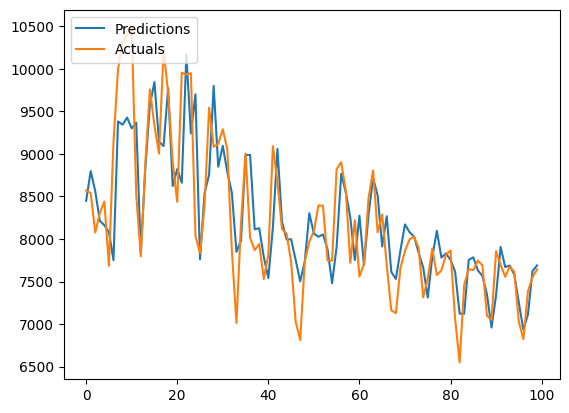

MAPE: 4.01%
RMSE: 422.88
MAE : 318.16


Predictions      Actuals
0    8448.575195  8569.568125
1    8798.015625  8540.904167
2    8562.979492  8076.513125
3    8213.405273  8302.971875
4    8161.735840  8440.820000
..           ...          ...
353  7618.771973  7508.199792
354  7754.320801  7694.271458
355  7616.948730  7746.240833
356  7619.041016  8321.401042
357  7928.545898  8503.726875

[358 rows x 2 columns]

In [56]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [57]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [58]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0468 - root_mean_squared_error: 0.2136 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - root_mean_squared_error: 0.1376 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1282 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [60]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.49%
RMSE: 380.24
MAE : 284.11


Predictions      Actuals
0    8129.544922  9098.258333
1    9394.788086  9070.002917
2    8688.271484  9125.678750
3    9114.695312  9368.951875
4    7518.423340  7510.325833
..           ...          ...
716  7472.390137  7374.332292
717  7768.167480  8039.583333
718  8052.753418  8575.767292
719  8290.909180  7909.507917
720  7381.627930  7144.386250

[721 rows x 2 columns]

In [61]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.61%
RMSE: 378.84
MAE : 288.56


Predictions      Actuals
0    8288.874023  8194.981667
1    7846.736328  9096.434375
2    9047.313477  8261.405417
3    7851.258789  6761.608125
4    7321.255859  7536.762292
..           ...          ...
350  7687.813965  8447.030417
351  8197.882812  8771.408958
352  8370.414062  8487.014792
353  7874.014160  8380.489792
354  7755.341797  8437.980833

[355 rows x 2 columns]

In [62]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.87%
RMSE: 412.62
MAE : 309.45


Predictions      Actuals
0    8163.392578  8302.971875
1    7983.802734  8440.820000
2    7952.220215  7684.176042
3    7825.355957  9135.772083
4    9495.188477  9995.508542
..           ...          ...
350  7656.776367  7508.199792
351  7822.245117  7694.271458
352  7889.681641  7746.240833
353  7819.408691  8321.401042
354  8227.935547  8503.726875

[355 rows x 2 columns]

## Model 8 - Decrease Window Size to 5 ##

In [63]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [64]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0747 - root_mean_squared_error: 0.2704 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1354 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


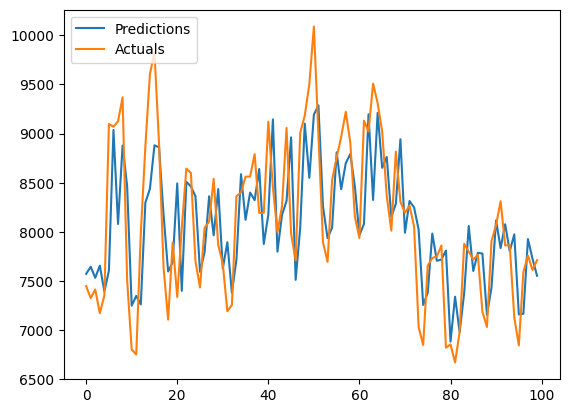

MAPE: 4.35%
RMSE: 463.32
MAE : 349.75


Predictions      Actuals
0    7571.773926  7446.897083
1    7644.423828  7324.388958
2    7531.562988  7412.811667
3    7655.869629  7171.183125
4    7393.017090  7350.264167
..           ...          ...
721  7335.249512  7374.332292
722  7746.495117  8039.583333
723  8045.550293  8575.767292
724  8325.783203  7909.507917
725  7417.323242  7144.386250

[726 rows x 2 columns]

In [66]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

In [67]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 4.04%
RMSE: 407.19
MAE : 320.73


Predictions      Actuals
0    8070.049805  8428.290208
1    8306.743164  9279.195417
2    8669.082031  9537.097917
3    8850.433594  8863.333125
4    7995.862305  7973.787500
..           ...          ...
355  7668.381836  8447.030417
356  8220.679688  8771.408958
357  8197.560547  8487.014792
358  7971.504395  8380.489792
359  8097.636230  8437.980833

[360 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


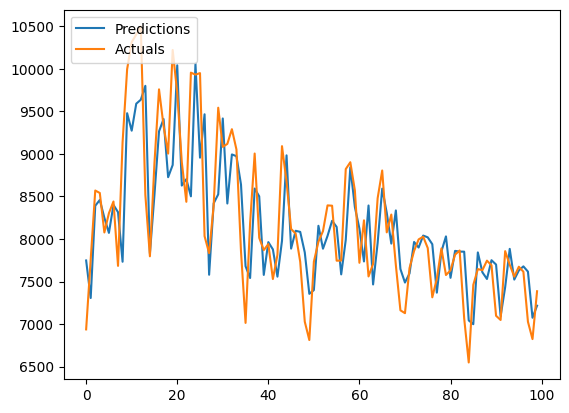

MAPE: 4.25%
RMSE: 438.57
MAE : 335.85


Predictions      Actuals
0    7747.622559  6937.700208
1    7306.537109  7759.521667
2    8390.625977  8569.568125
3    8458.965820  8540.904167
4    8250.013672  8076.513125
..           ...          ...
355  7579.563965  7508.199792
356  7738.069824  7694.271458
357  7740.238770  7746.240833
358  7748.186523  8321.401042
359  8253.720703  8503.726875

[360 rows x 2 columns]

In [68]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [69]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [70]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0751 - root_mean_squared_error: 0.2691 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


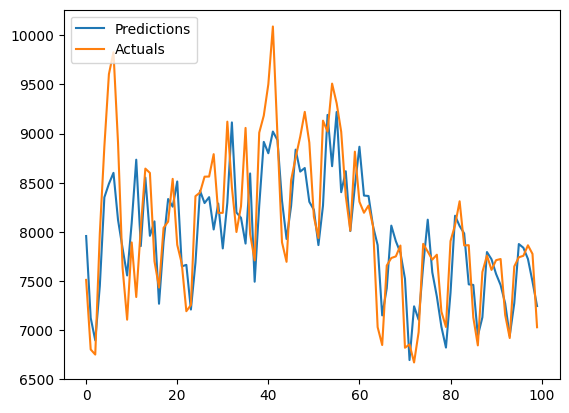

MAPE: 3.68%
RMSE: 404.45
MAE : 299.18


Predictions      Actuals
0    7957.031738  7510.325833
1    7123.666016  6801.918750
2    6894.386719  6750.140625
3    7447.296875  7981.096667
4    8351.104492  8868.038333
..           ...          ...
712  7494.038086  7374.332292
713  7757.370605  8039.583333
714  8037.866699  8575.767292
715  8145.437988  7909.507917
716  7388.291504  7144.386250

[717 rows x 2 columns]

In [72]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


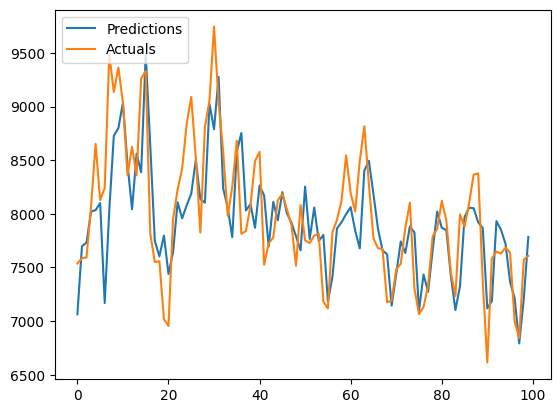

MAPE: 3.41%
RMSE: 359.51
MAE : 273.22


Predictions      Actuals
0    7063.813477  7536.762292
1    7697.982422  7586.311250
2    7732.408691  7593.115208
3    8021.019043  8067.645208
4    8033.962402  8651.321042
..           ...          ...
346  7706.664551  8447.030417
347  8000.352539  8771.408958
348  8091.719238  8487.014792
349  7764.182617  8380.489792
350  7901.223145  8437.980833

[351 rows x 2 columns]

In [73]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


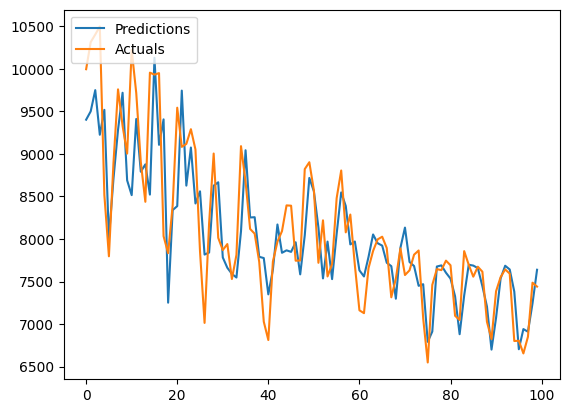

MAPE: 3.82%
RMSE: 404.51
MAE : 305.95


Predictions       Actuals
0    9402.158203   9995.508542
1    9500.300781  10313.686458
2    9749.374023  10402.964375
3    9225.222656  10497.618958
4    9517.850586   8517.349375
..           ...           ...
346  7397.298828   7508.199792
347  7483.881836   7694.271458
348  7660.602051   7746.240833
349  7625.340820   8321.401042
350  8117.945801   8503.726875

[351 rows x 2 columns]

In [74]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [75]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [76]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [77]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0263 - root_mean_squared_error: 0.1611 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


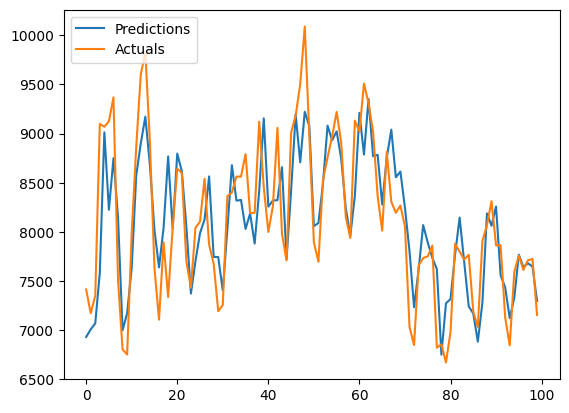

MAPE: 3.60%
RMSE: 396.28
MAE : 289.39


Predictions      Actuals
0    6928.935547  7412.811667
1    7006.350098  7171.183125
2    7066.869629  7350.264167
3    7583.337891  9098.258333
4    9012.863281  9070.002917
..           ...          ...
719  7888.279785  7374.332292
720  8103.532715  8039.583333
721  8183.115234  8575.767292
722  8166.841797  7909.507917
723  7231.030762  7144.386250

[724 rows x 2 columns]

In [79]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


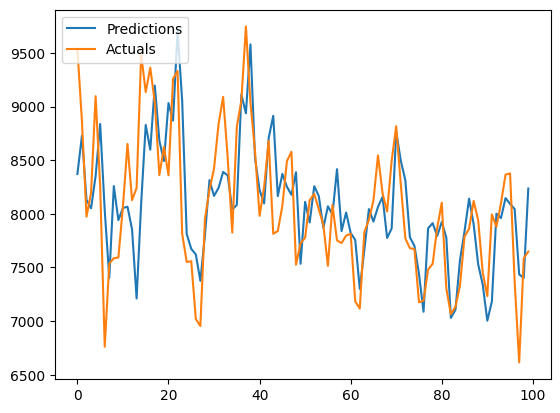

MAPE: 3.62%
RMSE: 376.89
MAE : 287.64


Predictions      Actuals
0    8370.457031  9537.097917
1    8727.988281  8863.333125
2    8129.490723  7973.787500
3    8051.562988  8194.981667
4    8352.400391  9096.434375
..           ...          ...
353  7953.650391  8447.030417
354  8233.034180  8771.408958
355  8258.531250  8487.014792
356  7791.801270  8380.489792
357  7796.632812  8437.980833

[358 rows x 2 columns]

In [80]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


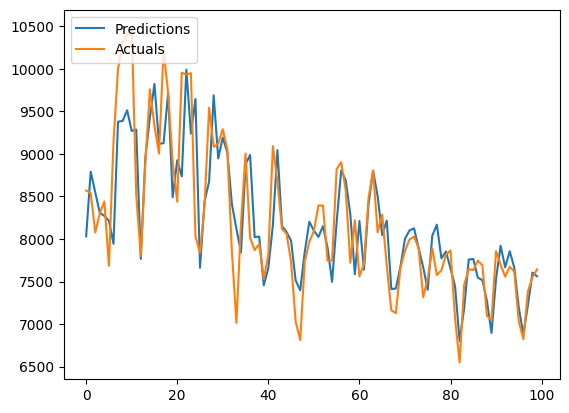

MAPE: 3.91%
RMSE: 411.12
MAE : 310.08


Predictions      Actuals
0    8030.278320  8569.568125
1    8791.858398  8540.904167
2    8548.319336  8076.513125
3    8307.824219  8302.971875
4    8270.895508  8440.820000
..           ...          ...
353  7857.590332  7508.199792
354  7822.749023  7694.271458
355  7894.250000  7746.240833
356  7751.112305  8321.401042
357  7833.343262  8503.726875

[358 rows x 2 columns]

In [81]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [82]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [83]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [84]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1278 - root_mean_squared_error: 0.3448 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [86]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


MAPE: 3.61%
RMSE: 397.02
MAE : 290.26


Predictions      Actuals
0    6927.540527  7412.811667
1    6959.270996  7171.183125
2    7067.601562  7350.264167
3    7543.034668  9098.258333
4    8952.324219  9070.002917
..           ...          ...
719  7997.749023  7374.332292
720  8195.764648  8039.583333
721  8225.182617  8575.767292
722  8202.202148  7909.507917
723  7440.366699  7144.386250

[724 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


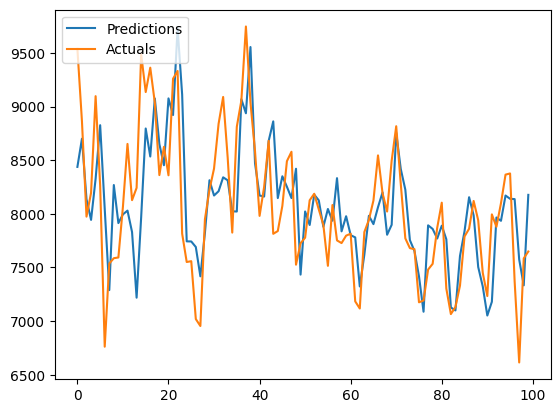

MAPE: 3.66%
RMSE: 381.73
MAE : 290.51


Predictions      Actuals
0    8437.262695  9537.097917
1    8699.806641  8863.333125
2    8136.610840  7973.787500
3    7943.590820  8194.981667
4    8326.452148  9096.434375
..           ...          ...
353  7971.809570  8447.030417
354  8223.063477  8771.408958
355  8250.589844  8487.014792
356  7804.610840  8380.489792
357  7725.433105  8437.980833

[358 rows x 2 columns]

In [87]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


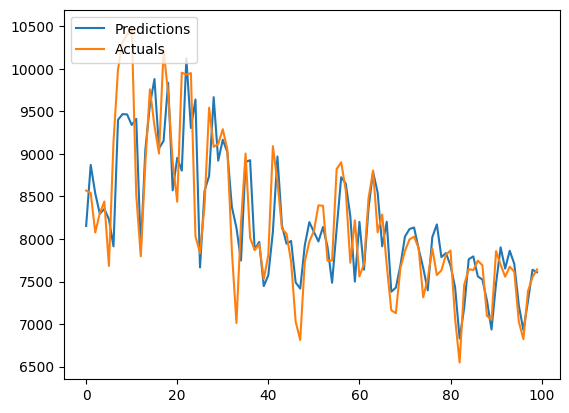

MAPE: 3.98%
RMSE: 416.92
MAE : 315.29


Predictions      Actuals
0    8153.460938  8569.568125
1    8871.107422  8540.904167
2    8535.916992  8076.513125
3    8295.785156  8302.971875
4    8353.618164  8440.820000
..           ...          ...
353  7903.625000  7508.199792
354  7938.252441  7694.271458
355  7866.290527  7746.240833
356  7738.485352  8321.401042
357  7712.451172  8503.726875

[358 rows x 2 columns]

In [88]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [89]:
tempPrecipDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [90]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [91]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0951 - root_mean_squared_error: 0.3001 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


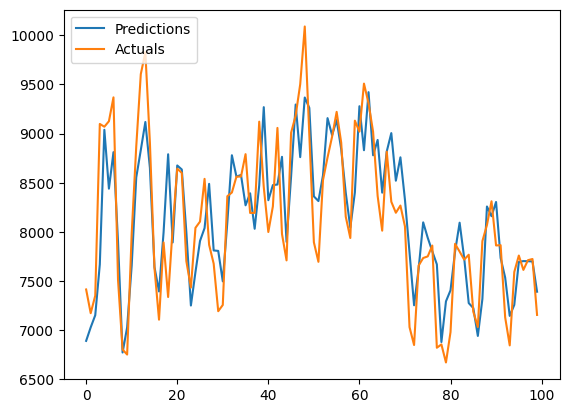

MAPE: 3.44%
RMSE: 374.20
MAE : 275.85


Predictions      Actuals
0    6889.395020  7412.811667
1    7027.097656  7171.183125
2    7150.584473  7350.264167
3    7668.206055  9098.258333
4    9038.918945  9070.002917
..           ...          ...
719  7977.577148  7374.332292
720  8228.400391  8039.583333
721  8302.420898  8575.767292
722  8038.632324  7909.507917
723  7357.334961  7144.386250

[724 rows x 2 columns]

In [93]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


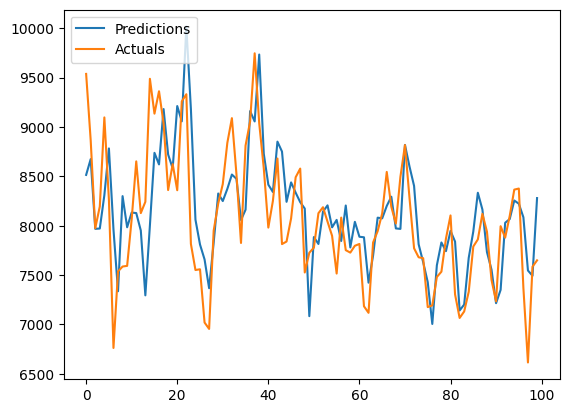

MAPE: 3.54%
RMSE: 371.20
MAE : 280.32


Predictions      Actuals
0    8514.290039  9537.097917
1    8674.620117  8863.333125
2    7967.996094  7973.787500
3    7971.229492  8194.981667
4    8309.538086  9096.434375
..           ...          ...
353  8103.492188  8447.030417
354  8400.364258  8771.408958
355  8428.695312  8487.014792
356  7987.699707  8380.489792
357  7886.107910  8437.980833

[358 rows x 2 columns]

In [94]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


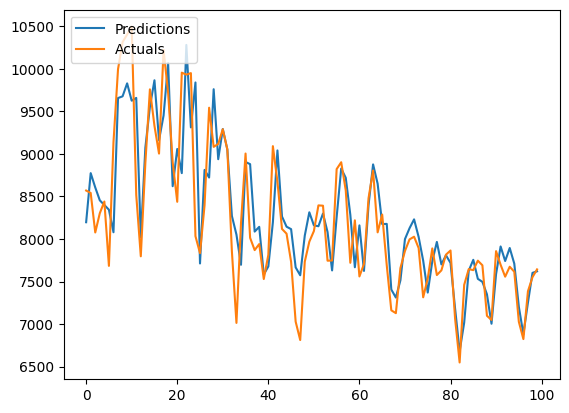

MAPE: 3.97%
RMSE: 408.75
MAE : 313.00


Predictions      Actuals
0    8197.108398  8569.568125
1    8774.168945  8540.904167
2    8605.670898  8076.513125
3    8454.449219  8302.971875
4    8399.339844  8440.820000
..           ...          ...
353  8076.650879  7508.199792
354  8126.295898  7694.271458
355  8094.034180  7746.240833
356  7976.031250  8321.401042
357  8012.677734  8503.726875

[358 rows x 2 columns]

In [95]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [96]:
tempSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [97]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [98]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1013 - root_mean_squared_error: 0.3080 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


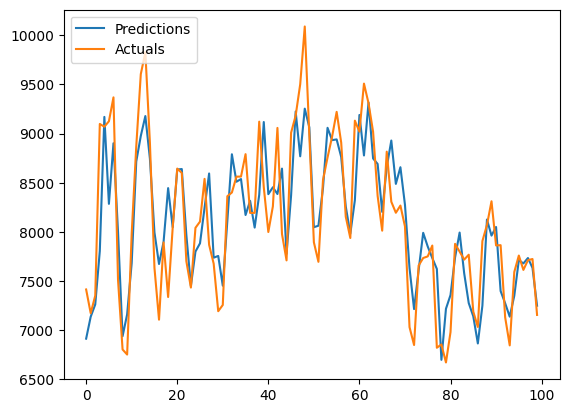

MAPE: 3.59%
RMSE: 387.36
MAE : 287.05


Predictions      Actuals
0    6911.840820  7412.811667
1    7135.094238  7171.183125
2    7260.749023  7350.264167
3    7804.911621  9098.258333
4    9170.035156  9070.002917
..           ...          ...
719  7717.562988  7374.332292
720  8151.885254  8039.583333
721  8111.023926  8575.767292
722  8025.903809  7909.507917
723  7267.479492  7144.386250

[724 rows x 2 columns]

In [100]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


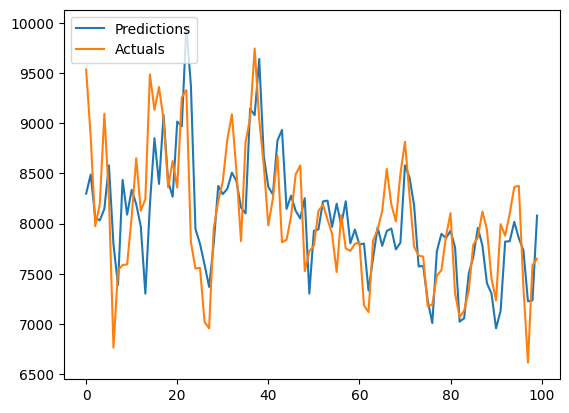

MAPE: 3.77%
RMSE: 391.32
MAE : 299.24


Predictions      Actuals
0    8298.069336  9537.097917
1    8488.960938  8863.333125
2    8057.355469  7973.787500
3    8031.156738  8194.981667
4    8146.152832  9096.434375
..           ...          ...
353  8204.581055  8447.030417
354  8526.748047  8771.408958
355  8521.881836  8487.014792
356  8096.239746  8380.489792
357  8022.130859  8437.980833

[358 rows x 2 columns]

In [101]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


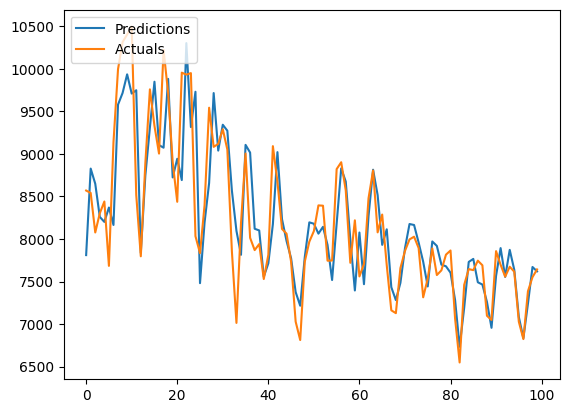

MAPE: 3.95%
RMSE: 412.28
MAE : 312.09


Predictions      Actuals
0    7810.806152  8569.568125
1    8827.664062  8540.904167
2    8649.252930  8076.513125
3    8259.315430  8302.971875
4    8201.007812  8440.820000
..           ...          ...
353  7901.147949  7508.199792
354  8001.775879  7694.271458
355  8118.874512  7746.240833
356  7907.532227  8321.401042
357  7967.071289  8503.726875

[358 rows x 2 columns]

In [102]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

## Model 14 - Precipitation and Sunlight ##

In [103]:
tempPreSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [104]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [105]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0487 - root_mean_squared_error: 0.2177 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

In [107]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


MAPE: 3.50%
RMSE: 383.04
MAE : 281.36


Predictions      Actuals
0    6862.827637  7412.811667
1    7097.520996  7171.183125
2    7207.637695  7350.264167
3    7761.465332  9098.258333
4    9066.553711  9070.002917
..           ...          ...
719  7762.999023  7374.332292
720  8247.035156  8039.583333
721  8191.533691  8575.767292
722  7955.419922  7909.507917
723  7326.142578  7144.386250

[724 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


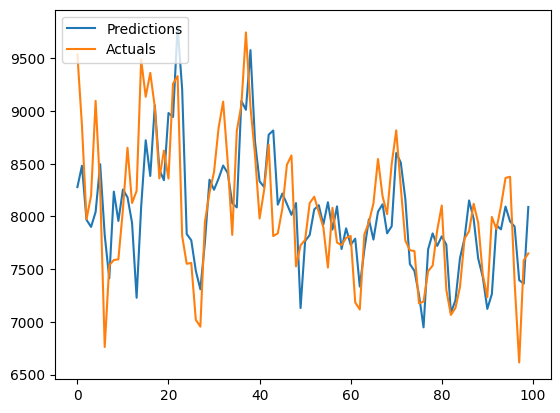

MAPE: 3.58%
RMSE: 373.77
MAE : 284.33


Predictions      Actuals
0    8278.249023  9537.097917
1    8480.566406  8863.333125
2    7968.050293  7973.787500
3    7900.453125  8194.981667
4    8042.199707  9096.434375
..           ...          ...
353  8228.286133  8447.030417
354  8505.692383  8771.408958
355  8396.675781  8487.014792
356  7910.048340  8380.489792
357  7856.428711  8437.980833

[358 rows x 2 columns]

In [108]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


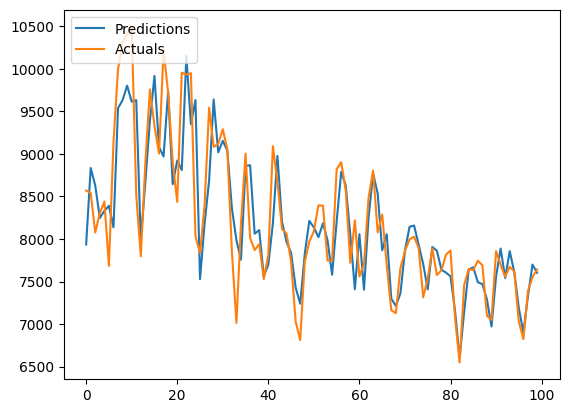

MAPE: 3.91%
RMSE: 405.48
MAE : 308.37


Predictions      Actuals
0    7935.577148  8569.568125
1    8834.210938  8540.904167
2    8628.374023  8076.513125
3    8247.638672  8302.971875
4    8329.592773  8440.820000
..           ...          ...
353  8085.630371  7508.199792
354  8126.725586  7694.271458
355  8175.144531  7746.240833
356  7966.217773  8321.401042
357  7901.193359  8503.726875

[358 rows x 2 columns]

In [109]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

In [110]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [111]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [112]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [113]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2117 - root_mean_squared_error: 0.4423 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1478
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


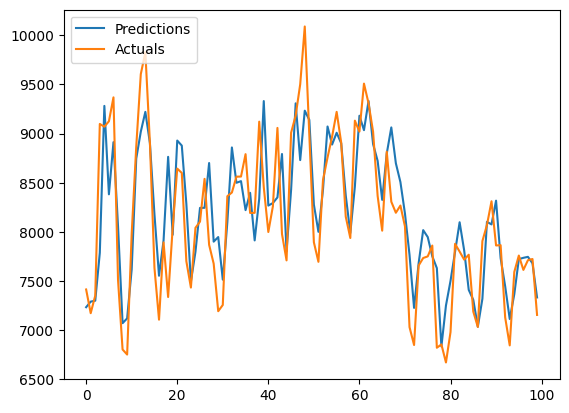

MAPE: 3.46%
RMSE: 380.69
MAE : 277.42


Predictions      Actuals
0    7232.283691  7412.811667
1    7289.068359  7171.183125
2    7298.492676  7350.264167
3    7786.399902  9098.258333
4    9282.088867  9070.002917
..           ...          ...
719  7966.237305  7374.332292
720  8328.987305  8039.583333
721  8323.537109  8575.767292
722  8179.529785  7909.507917
723  7284.453613  7144.386250

[724 rows x 2 columns]

In [115]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


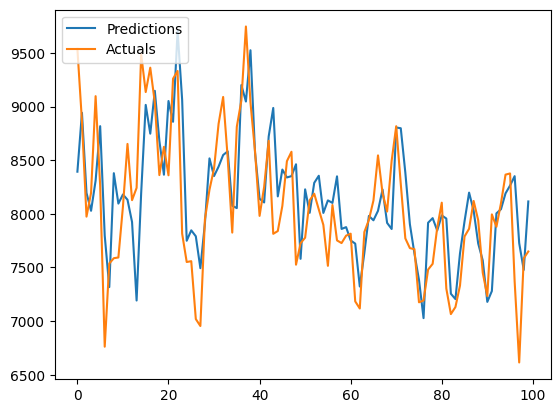

MAPE: 3.55%
RMSE: 376.00
MAE : 281.20


Predictions      Actuals
0    8392.559570  9537.097917
1    8941.527344  8863.333125
2    8194.640625  7973.787500
3    8027.960449  8194.981667
4    8309.337891  9096.434375
..           ...          ...
353  8185.332031  8447.030417
354  8491.319336  8771.408958
355  8326.375977  8487.014792
356  7776.930664  8380.489792
357  7658.316406  8437.980833

[358 rows x 2 columns]

In [116]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


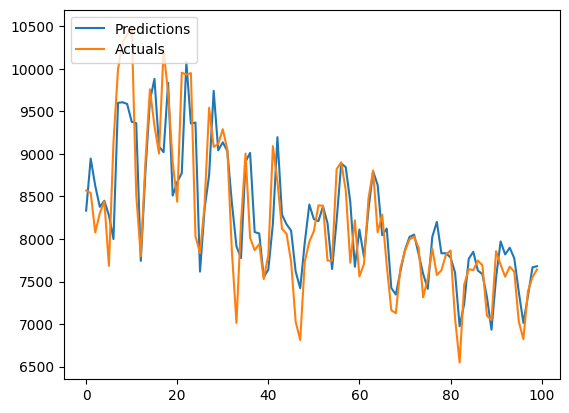

MAPE: 3.74%
RMSE: 394.31
MAE : 295.55


Predictions      Actuals
0    8333.276367  8569.568125
1    8945.306641  8540.904167
2    8624.919922  8076.513125
3    8377.613281  8302.971875
4    8449.673828  8440.820000
..           ...          ...
353  8042.147949  7508.199792
354  8084.419922  7694.271458
355  8061.265625  7746.240833
356  7925.679199  8321.401042
357  7918.588867  8503.726875

[358 rows x 2 columns]

In [117]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [118]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [119]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [120]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1146 - root_mean_squared_error: 0.3284 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


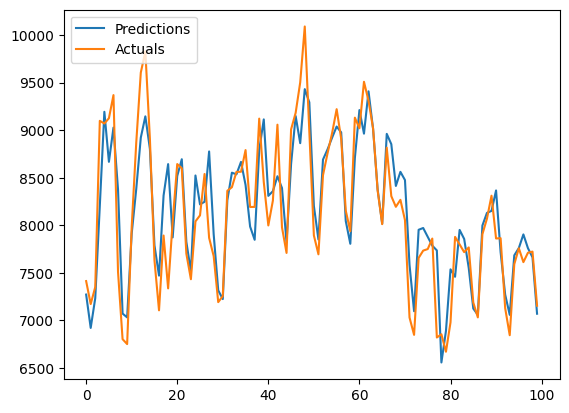

MAPE: 2.89%
RMSE: 330.78
MAE : 231.68


Predictions      Actuals
0    7270.975586  7412.811667
1    6920.201172  7171.183125
2    7232.826172  7350.264167
3    8204.054688  9098.258333
4    9193.333984  9070.002917
..           ...          ...
719  7415.696289  7374.332292
720  7874.430664  8039.583333
721  8108.979492  8575.767292
722  7808.563965  7909.507917
723  7367.317383  7144.386250

[724 rows x 2 columns]

In [122]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


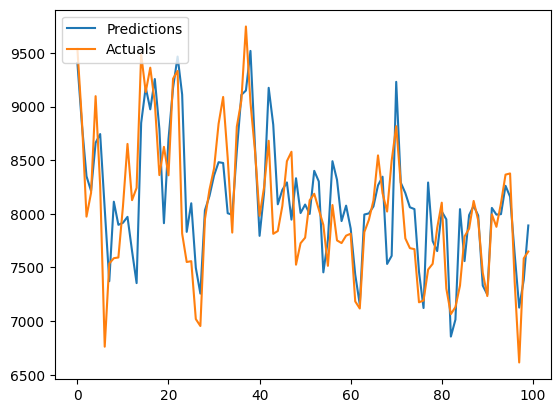

MAPE: 3.07%
RMSE: 333.41
MAE : 242.40


Predictions      Actuals
0    9405.763672  9537.097917
1    8828.664062  8863.333125
2    8350.083008  7973.787500
3    8213.216797  8194.981667
4    8662.310547  9096.434375
..           ...          ...
353  7667.598145  8447.030417
354  8075.603516  8771.408958
355  7699.835449  8487.014792
356  7646.146973  8380.489792
357  8577.567383  8437.980833

[358 rows x 2 columns]

In [123]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


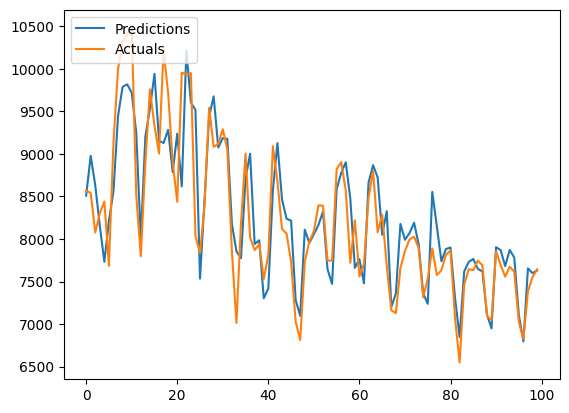

MAPE: 3.28%
RMSE: 356.61
MAE : 259.92


Predictions      Actuals
0    8509.632812  8569.568125
1    8976.618164  8540.904167
2    8632.107422  8076.513125
3    8153.110840  8302.971875
4    7732.131348  8440.820000
..           ...          ...
353  7392.494141  7508.199792
354  7089.070801  7694.271458
355  7578.461426  7746.240833
356  8451.411133  8321.401042
357  8383.551758  8503.726875

[358 rows x 2 columns]

In [124]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [125]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [126]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [127]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0635 - root_mean_squared_error: 0.2462 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


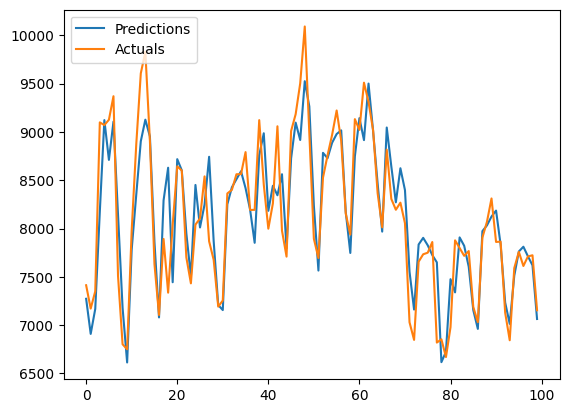

MAPE: 2.55%
RMSE: 294.33
MAE : 204.48


Predictions      Actuals
0    7272.527832  7412.811667
1    6909.353516  7171.183125
2    7167.884766  7350.264167
3    8172.948730  9098.258333
4    9121.831055  9070.002917
..           ...          ...
719  7023.519531  7374.332292
720  7930.803223  8039.583333
721  7876.744141  8575.767292
722  7812.128418  7909.507917
723  7250.570801  7144.386250

[724 rows x 2 columns]

In [129]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


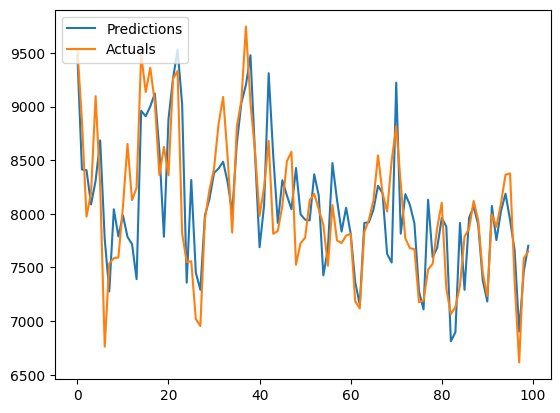

MAPE: 2.89%
RMSE: 318.50
MAE : 229.16


Predictions      Actuals
0    9475.941406  9537.097917
1    8412.625000  8863.333125
2    8406.615234  7973.787500
3    8088.141113  8194.981667
4    8307.725586  9096.434375
..           ...          ...
353  7579.134277  8447.030417
354  8017.740723  8771.408958
355  7854.922363  8487.014792
356  7575.106934  8380.489792
357  8614.588867  8437.980833

[358 rows x 2 columns]

In [130]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

In [131]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.22%
RMSE: 357.78
MAE : 257.35


Predictions      Actuals
0    8459.838867  8569.568125
1    9054.734375  8540.904167
2    8376.677734  8076.513125
3    8056.024902  8302.971875
4    7792.752441  8440.820000
..           ...          ...
353  7183.500000  7508.199792
354  7033.205566  7694.271458
355  7488.713867  7746.240833
356  8528.805664  8321.401042
357  8053.733398  8503.726875

[358 rows x 2 columns]

## Month ##

In [132]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [133]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [134]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1175 - root_mean_squared_error: 0.3319 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1250 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - root_mean_squared_error: 0.1238 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


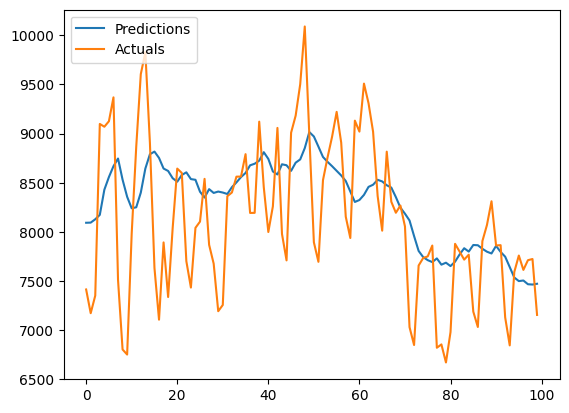

MAPE: 5.49%
RMSE: 567.24
MAE : 431.47


Predictions      Actuals
0    8092.113281  7412.811667
1    8093.579590  7171.183125
2    8127.599609  7350.264167
3    8172.789062  9098.258333
4    8428.902344  9070.002917
..           ...          ...
719  7967.032715  7374.332292
720  7948.735840  8039.583333
721  8009.375977  8575.767292
722  8129.465820  7909.507917
723  8175.483887  7144.386250

[724 rows x 2 columns]

In [136]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


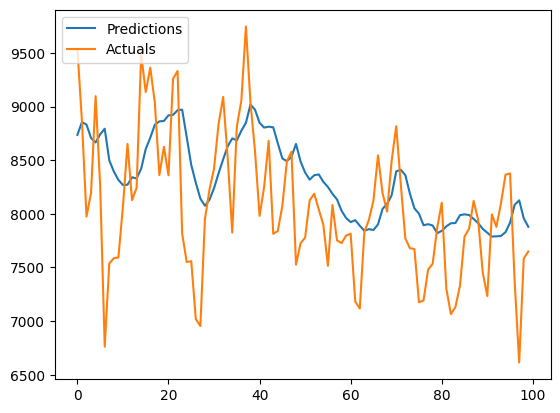

MAPE: 5.06%
RMSE: 502.17
MAE : 392.16


Predictions      Actuals
0    8734.942383  9537.097917
1    8855.005859  8863.333125
2    8831.186523  7973.787500
3    8706.076172  8194.981667
4    8664.954102  9096.434375
..           ...          ...
353  7836.713379  8447.030417
354  7924.553223  8771.408958
355  8100.164551  8487.014792
356  8217.507812  8380.489792
357  8295.145508  8437.980833

[358 rows x 2 columns]

In [137]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


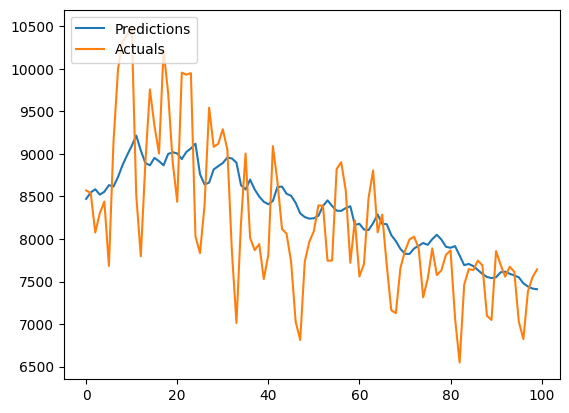

MAPE: 5.58%
RMSE: 563.99
MAE : 432.30


Predictions      Actuals
0    8471.200195  8569.568125
1    8546.518555  8540.904167
2    8584.872070  8076.513125
3    8521.438477  8302.971875
4    8555.265625  8440.820000
..           ...          ...
353  7964.777344  7508.199792
354  8012.341797  7694.271458
355  8065.162598  7746.240833
356  8106.310059  8321.401042
357  8170.154297  8503.726875

[358 rows x 2 columns]

In [138]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [139]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [140]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [141]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0583 - root_mean_squared_error: 0.2344 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


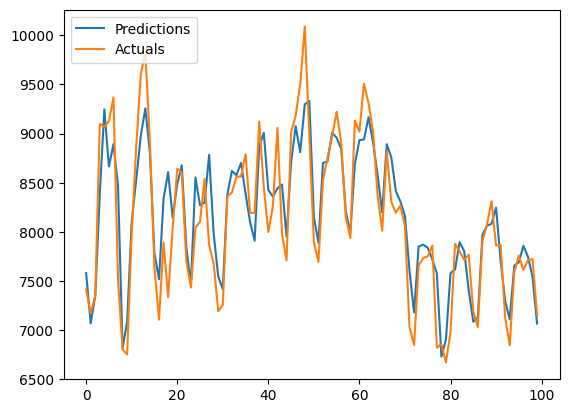

MAPE: 3.03%
RMSE: 348.25
MAE : 243.09


Predictions      Actuals
0    7579.554688  7412.811667
1    7068.139648  7171.183125
2    7346.613281  7350.264167
3    8388.378906  9098.258333
4    9247.292969  9070.002917
..           ...          ...
719  7668.269531  7374.332292
720  8097.272461  8039.583333
721  8109.537109  8575.767292
722  7936.139648  7909.507917
723  7483.645020  7144.386250

[724 rows x 2 columns]

In [143]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


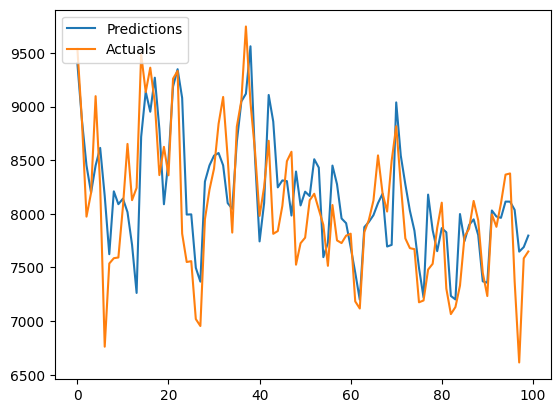

MAPE: 3.22%
RMSE: 346.92
MAE : 253.53


Predictions      Actuals
0    9400.727539  9537.097917
1    8871.778320  8863.333125
2    8449.970703  7973.787500
3    8197.175781  8194.981667
4    8450.486328  9096.434375
..           ...          ...
353  7934.476074  8447.030417
354  7999.895020  8771.408958
355  7864.303711  8487.014792
356  7623.917969  8380.489792
357  8593.796875  8437.980833

[358 rows x 2 columns]

In [144]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


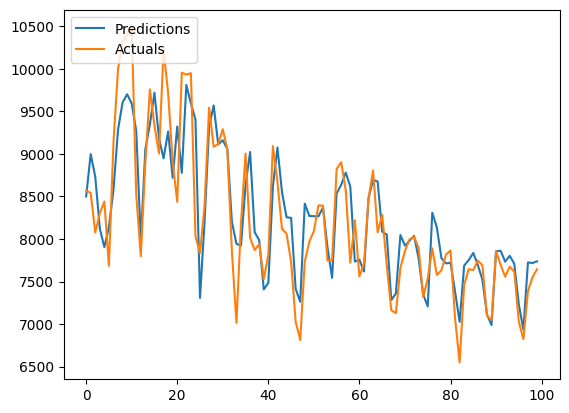

MAPE: 3.46%
RMSE: 374.90
MAE : 273.15


Predictions      Actuals
0    8500.235352  8569.568125
1    8997.556641  8540.904167
2    8732.576172  8076.513125
3    8124.261230  8302.971875
4    7903.522461  8440.820000
..           ...          ...
353  7629.048340  7508.199792
354  7218.255859  7694.271458
355  7445.551758  7746.240833
356  8344.540039  8321.401042
357  8410.710938  8503.726875

[358 rows x 2 columns]

In [145]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [146]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [147]:
model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0415 - root_mean_squared_error: 0.1989
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


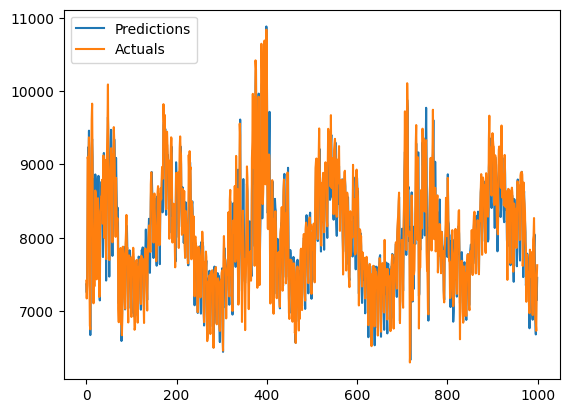

MAPE: 2.41%
RMSE: 274.10
MAE : 193.88


Predictions      Actuals
0     7364.265625  7412.811667
1     7252.565430  7171.183125
2     7371.411133  7350.264167
3     8166.271973  9098.258333
4     9231.331055  9070.002917
...           ...          ...
1084  8154.125488  8447.030417
1085  8930.920898  8771.408958
1086  8237.861328  8487.014792
1087  8045.483887  8380.489792
1088  8278.926758  8437.980833

[1089 rows x 2 columns]

In [149]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


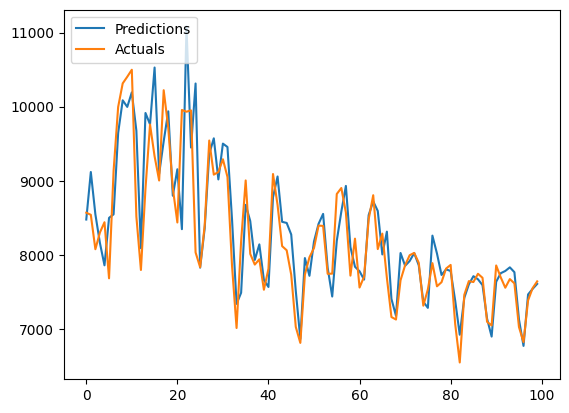

MAPE: 2.99%
RMSE: 351.01
MAE : 239.18


Predictions      Actuals
0    8477.250000  8569.568125
1    9118.291016  8540.904167
2    8547.446289  8076.513125
3    8159.973145  8302.971875
4    7859.455078  8440.820000
..           ...          ...
353  7565.323242  7508.199792
354  7719.040039  7694.271458
355  8142.357910  7746.240833
356  8463.887695  8321.401042
357  7944.074219  8503.726875

[358 rows x 2 columns]

In [150]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [151]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [152]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0564 - root_mean_squared_error: 0.2304
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


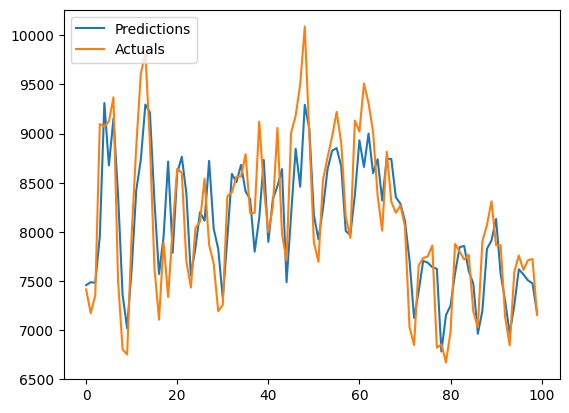

MAPE: 3.16%
RMSE: 346.39
MAE : 254.78


Predictions      Actuals
0     7456.769531  7412.811667
1     7486.437988  7171.183125
2     7481.193848  7350.264167
3     7952.283203  9098.258333
4     9311.445312  9070.002917
...           ...          ...
1084  8079.838379  8447.030417
1085  8613.079102  8771.408958
1086  8659.134766  8487.014792
1087  8098.170898  8380.489792
1088  8000.882324  8437.980833

[1089 rows x 2 columns]

In [154]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


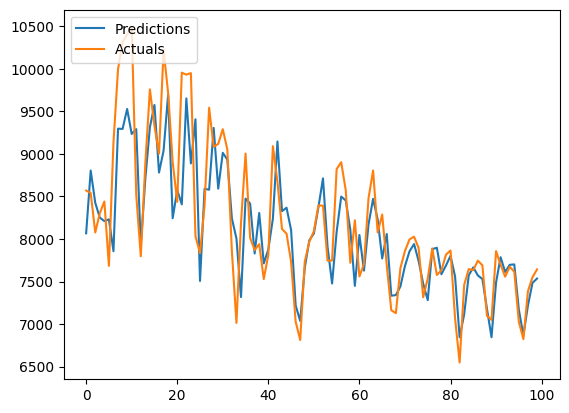

MAPE: 3.59%
RMSE: 393.36
MAE : 286.01


Predictions      Actuals
0    8066.934570  8569.568125
1    8804.912109  8540.904167
2    8425.260742  8076.513125
3    8251.103516  8302.971875
4    8210.698242  8440.820000
..           ...          ...
353  7888.485840  7508.199792
354  7992.210449  7694.271458
355  8003.485352  7746.240833
356  7829.659180  8321.401042
357  8116.863770  8503.726875

[358 rows x 2 columns]

In [155]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [156]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [157]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0305 - root_mean_squared_error: 0.1726
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0987
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0972
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


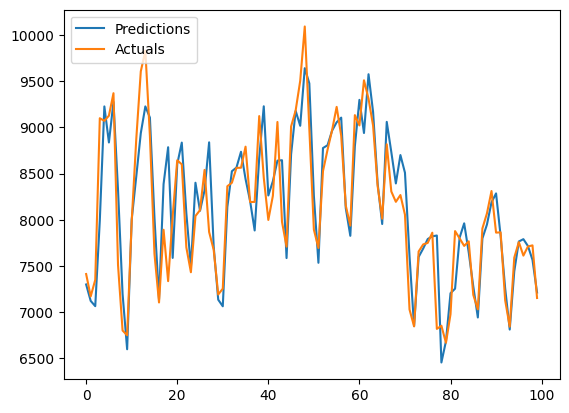

MAPE: 2.62%
RMSE: 293.17
MAE : 209.89


Predictions      Actuals
0     7299.909668  7412.811667
1     7122.137695  7171.183125
2     7065.335449  7350.264167
3     7992.876465  9098.258333
4     9226.021484  9070.002917
...           ...          ...
1084  7669.876465  8447.030417
1085  8392.160156  8771.408958
1086  7934.970703  8487.014792
1087  7856.623047  8380.489792
1088  8334.403320  8437.980833

[1089 rows x 2 columns]

In [159]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


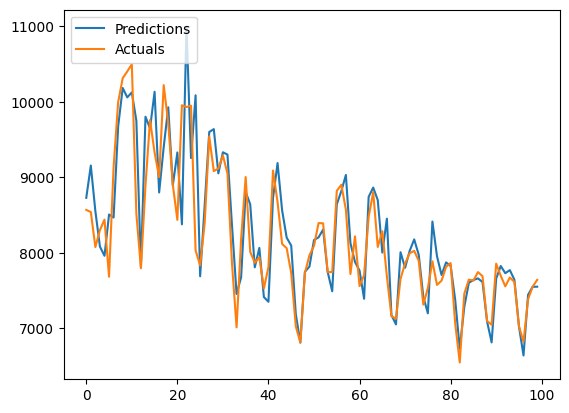

MAPE: 2.94%
RMSE: 339.19
MAE : 234.84


Predictions      Actuals
0    8729.216797  8569.568125
1    9156.825195  8540.904167
2    8551.425781  8076.513125
3    8083.045898  8302.971875
4    7961.777832  8440.820000
..           ...          ...
353  7380.458008  7508.199792
354  7414.757324  7694.271458
355  7768.862305  7746.240833
356  8443.815430  8321.401042
357  8143.304199  8503.726875

[358 rows x 2 columns]

In [160]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [161]:
## !pip install Optuna

In [162]:
'''study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=50) '''

"study = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy.optimize(objective, n_trials=50) "

## Model 20 Re-Run (Post Optuna) ##

In [168]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

i = X_train23.shape[1]
j = X_train23.shape[2]

In [169]:
model23 = Sequential()
model23.add(InputLayer((i, j)))
model23.add(LSTM(88, dropout=0.02))
model23.add(Dense(8, 'tanh'))
model23.add(Dense(1, 'linear'))

model23.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 88)             │        35,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,625 (143.07 KB)

 Trainable params: 36,625 (143.07 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00087, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=32, callbacks=[cp23])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0832 - root_mean_squared_error: 0.2765
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1020

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


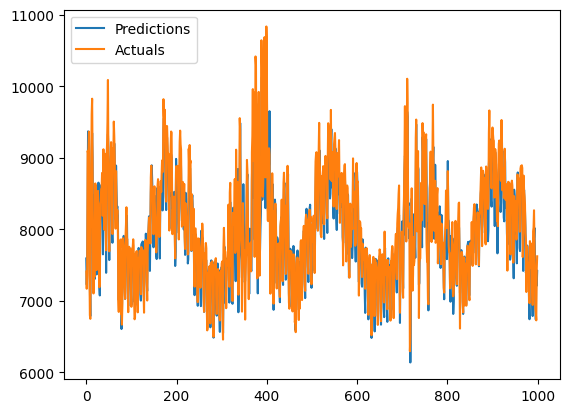

MAPE: 2.57%
RMSE: 289.41
MAE : 208.45


Predictions      Actuals
0     7594.329590  7412.811667
1     7228.186523  7171.183125
2     7439.606445  7350.264167
3     8286.455078  9098.258333
4     9371.824219  9070.002917
...           ...          ...
1084  8095.112793  8447.030417
1085  8731.013672  8771.408958
1086  8291.533203  8487.014792
1087  8080.542480  8380.489792
1088  8761.812500  8437.980833

[1089 rows x 2 columns]

In [171]:
model23 = load_model('model23.keras')

predictions_plot(model23, X_train23, y_train23, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


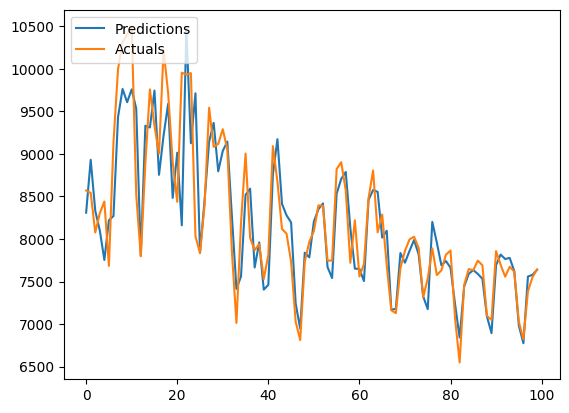

MAPE: 2.93%
RMSE: 341.34
MAE : 236.79


Predictions      Actuals
0    8309.326172  8569.568125
1    8930.730469  8540.904167
2    8331.792969  8076.513125
3    8100.360840  8302.971875
4    7753.579102  8440.820000
..           ...          ...
353  7610.104004  7508.199792
354  7572.333984  7694.271458
355  8083.332520  7746.240833
356  8688.286133  8321.401042
357  8465.551758  8503.726875

[358 rows x 2 columns]

In [172]:
predictions_plot(model23, X_test23, y_test23, 0, 100)